# it`s not official just use it as a test#

In [3]:
import camelot
from dotenv import load_dotenv
import arabic_reshaper
from bidi.algorithm import get_display
from joblib import Memory
from pdf2image import convert_from_path
from PIL import Image
import pytesseract
from pytesseract import Output
import os
import cv2
import numpy as np

In [4]:

# Define a directory for cache storage
memory = Memory("./cache_dir", verbose=0)


In [5]:
directory_path = r".\documents"

pdf_files = []
for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file.endswith('.pdf'):
            pdf_files.append({"path":os.path.join(root, file)})

# Print the list of PDF files with their paths
print("PDF files found:")
for pdf_file in pdf_files:
    print(pdf_file)


PDF files found:
{'path': '.\\documents\\الاثنين 16-12-2024 د19 القاهرة الجديدة.pdf'}
{'path': '.\\documents\\الاثنين جلسة 1-1-2024 د19.pdf'}
{'path': '.\\documents\\الاثنين جلسة 1-4-2024 د19 وراثات.pdf'}
{'path': '.\\documents\\د(19)اسرة السيدة زينب 22-12-2024.pdf'}
{'path': '.\\documents\\د(20)اسرة باب الشعرية 19-12-2024.pdf'}
{'path': '.\\documents\\د(20)اسرة عابدين18-12-2024.pdf'}
{'path': '.\\documents\\د(22) اسرة  الموسكى  جلسة 21-12-2024.pdf'}
{'path': '.\\documents\\وراثات الزاوية 16-12.pdf'}
{'path': '.\\documents\\وراثات الشرابية 17-12.pdf'}


In [6]:
def get_pdf_tables(pdf_docs):
    """
    this function reads the pdf files and extracts the tables from the first page of each pdf file and crop the first page as an image
    """
    for pdf in pdf_docs:
        print(pdf['path'])
        pdf_reader = camelot.read_pdf(pdf['path'],pages='all',) #address of pdf file(pdf)
        pdf.update({'tablelist':pdf_reader})
        pdf.update({'first_page_as_image':convert_from_path(pdf['path'], first_page=1, last_page=1, dpi=300,poppler_path=r".\libs\poppler-24.08.0\Library\bin")[0]})
        
get_pdf_tables(pdf_files)
print(pdf_files)

invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams


.\documents\الاثنين 16-12-2024 د19 القاهرة الجديدة.pdf


invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11724'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11479'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11479'
incorrect startxref pointer(1)
parsing for Object Streams


.\documents\الاثنين جلسة 1-1-2024 د19.pdf


invalid pdf header: b'11479'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11479'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11479'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'15576'
incorrect startxref pointer(3)
parsing for Object Streams
invalid pdf header: b'15576'
incorrect startxref pointer(3)
parsing for Object Streams


.\documents\الاثنين جلسة 1-4-2024 د19 وراثات.pdf


invalid pdf header: b'11710'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11710'
incorrect startxref pointer(1)
parsing for Object Streams


.\documents\د(19)اسرة السيدة زينب 22-12-2024.pdf


invalid pdf header: b'11710'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11710'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11715'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11715'


.\documents\د(20)اسرة باب الشعرية 19-12-2024.pdf


incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11715'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11715'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11715'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11715'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11714'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11714'


.\documents\د(20)اسرة عابدين18-12-2024.pdf


incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11714'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11714'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11714'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11714'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11696'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'11696'
incorrect startxref pointer(1)
parsing for Object Streams


.\documents\د(22) اسرة  الموسكى  جلسة 21-12-2024.pdf


invalid pdf header: b'11696'
incorrect startxref pointer(1)
parsing for Object Streams
invalid pdf header: b'16883'
incorrect startxref pointer(3)
parsing for Object Streams
invalid pdf header: b'16883'
incorrect startxref pointer(3)
parsing for Object Streams


.\documents\وراثات الزاوية 16-12.pdf


invalid pdf header: b'17255'
incorrect startxref pointer(3)
parsing for Object Streams
invalid pdf header: b'17255'
incorrect startxref pointer(3)


.\documents\وراثات الشرابية 17-12.pdf


parsing for Object Streams
invalid pdf header: b'17255'
incorrect startxref pointer(3)
parsing for Object Streams


[{'path': '.\\documents\\الاثنين 16-12-2024 د19 القاهرة الجديدة.pdf', 'tablelist': <TableList n=6>, 'first_page_as_image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2548CD7C220>}, {'path': '.\\documents\\الاثنين جلسة 1-1-2024 د19.pdf', 'tablelist': <TableList n=4>, 'first_page_as_image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2548D607850>}, {'path': '.\\documents\\الاثنين جلسة 1-4-2024 د19 وراثات.pdf', 'tablelist': <TableList n=1>, 'first_page_as_image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2548D660F40>}, {'path': '.\\documents\\د(19)اسرة السيدة زينب 22-12-2024.pdf', 'tablelist': <TableList n=3>, 'first_page_as_image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2548D1568F0>}, {'path': '.\\documents\\د(20)اسرة باب الشعرية 19-12-2024.pdf', 'tablelist': <TableList n=5>, 'first_page_as_image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2548CC65000>}, {'pat

In [7]:
def fix_arabic_text(cell): # Fix Arabic text direction
    try:
        reshaped_text = arabic_reshaper.reshape(cell)  # Reshape Arabic characters
        bidi_text = get_display(reshaped_text)  # Apply BiDi algorithm
        return bidi_text
    except Exception:
        return cell  # Return as is if not Arabic
    
def get_head_from_first_page(pdf): # Get the head of the table from the first page only of each PDF
        first_page = pdf[0]
        first_page.df = first_page.df.map(fix_arabic_text)
        # Access the table's structure
        cells = first_page.cells  # List of all detected cells
        head = [int(cells[0][0].x1), int(cells[0][0].y2), int(cells[0][-1].x2), int(cells[0][0].y1)]
        return head

for pdf in pdf_files:
    pdf.update({'head_coordinates':get_head_from_first_page(pdf['tablelist'])})

print(pdf_files)

[{'path': '.\\documents\\الاثنين 16-12-2024 د19 القاهرة الجديدة.pdf', 'tablelist': <TableList n=6>, 'first_page_as_image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2548CD7C220>, 'head_coordinates': [19, 822, 575, 619]}, {'path': '.\\documents\\الاثنين جلسة 1-1-2024 د19.pdf', 'tablelist': <TableList n=4>, 'first_page_as_image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2548D607850>, 'head_coordinates': [19, 822, 575, 638]}, {'path': '.\\documents\\الاثنين جلسة 1-4-2024 د19 وراثات.pdf', 'tablelist': <TableList n=1>, 'first_page_as_image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2548D660F40>, 'head_coordinates': [19, 822, 575, 664]}, {'path': '.\\documents\\د(19)اسرة السيدة زينب 22-12-2024.pdf', 'tablelist': <TableList n=3>, 'first_page_as_image': <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2480x3509 at 0x2548D1568F0>, 'head_coordinates': [19, 822, 575, 619]}, {'path': '.\\documents\\د(20)اسرة باب ال

## You don`t need to run this cell


In [8]:
%%script false
def check_on_pdf_grid(pdf_path,key):
    file_name =os.path.basename(pdf_path)
    nested_tables = camelot.read_pdf(pdf_path, pages='1',flavor='stream',table_areas=[head_coordinates[key]],edge_tol=500,)
    camelot.plot(table=nested_tables[0], kind="grid")
    
for pdf_path,key in zip(pdf_files,head_coordinates):
    print(pdf_path,key)
    check_on_pdf_grid(pdf_path,key)

Couldn't find program: 'false'


الاثنين 16-12-2024 د19 القاهرة الجديدة


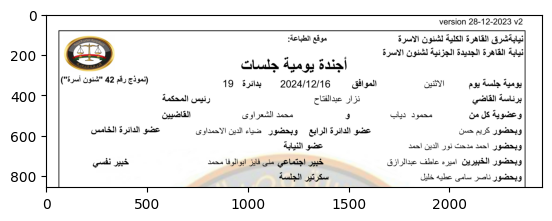

Minimum Intensity: 0.0
Maximum Intensity: 255.0
Minimum Intensity: 0
Maximum Intensity: 255
الاثنين جلسة 1-1-2024 د19


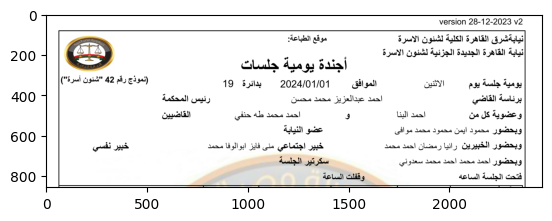

Minimum Intensity: 0.0
Maximum Intensity: 255.0
Minimum Intensity: 0
Maximum Intensity: 255
الاثنين جلسة 1-4-2024 د19 وراثات


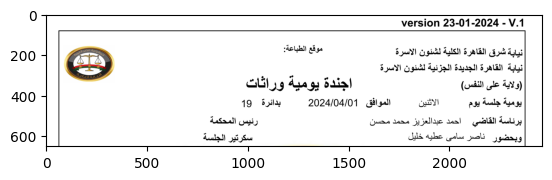

Minimum Intensity: 0.0
Maximum Intensity: 255.0
Minimum Intensity: 0
Maximum Intensity: 255
د(19)اسرة السيدة زينب 22-12-2024


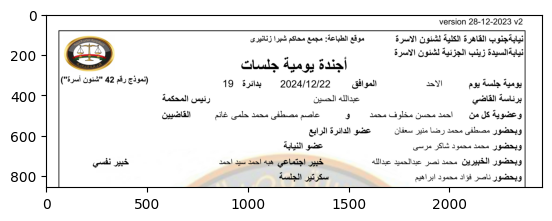

Minimum Intensity: 0.0
Maximum Intensity: 255.0
Minimum Intensity: 0
Maximum Intensity: 255
د(20)اسرة باب الشعرية 19-12-2024


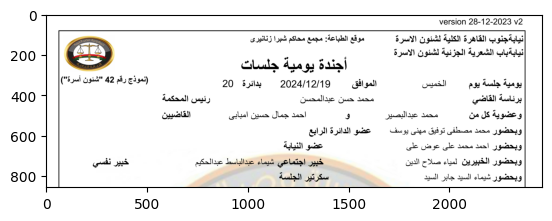

Minimum Intensity: 0.0
Maximum Intensity: 255.0
Minimum Intensity: 0
Maximum Intensity: 255
د(20)اسرة عابدين18-12-2024


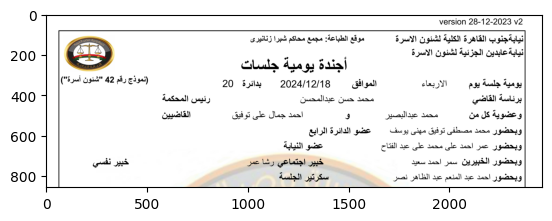

Minimum Intensity: 0.0
Maximum Intensity: 255.0
Minimum Intensity: 0
Maximum Intensity: 255
د(22) اسرة  الموسكى  جلسة 21-12-2024


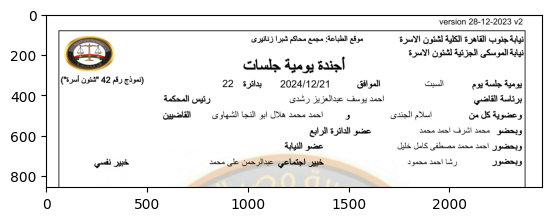

Minimum Intensity: 0.0
Maximum Intensity: 255.0
Minimum Intensity: 0
Maximum Intensity: 255
وراثات الزاوية 16-12


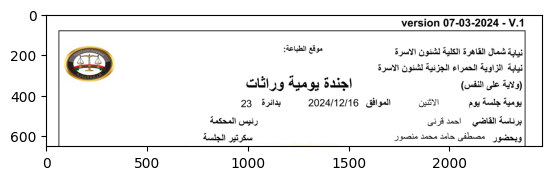

Minimum Intensity: 0.0
Maximum Intensity: 255.0
Minimum Intensity: 0
Maximum Intensity: 255
وراثات الشرابية 17-12


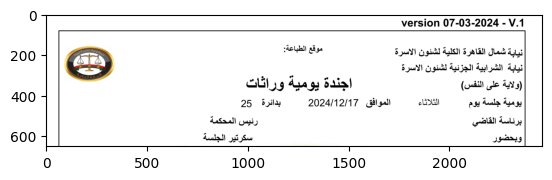

Minimum Intensity: 0.0
Maximum Intensity: 255.0
Minimum Intensity: 0
Maximum Intensity: 255


In [9]:

for pdf in pdf_files:
    pdf_name = os.path.basename(pdf['path']).split('.')[0]
    print(pdf_name)
    if pdf_name.__contains__('وراثات'):
        cropped_cell_image = pdf['first_page_as_image'].crop((pdf['head_coordinates'][0], 0, pdf['first_page_as_image'].width,(pdf['first_page_as_image'].height/100)+pdf['head_coordinates'][1]-205)) #x1,y2,x2,y1
    else:
        cropped_cell_image = pdf['first_page_as_image'].crop((pdf['head_coordinates'][0], 0, pdf['first_page_as_image'].width,(pdf['first_page_as_image'].height/100)+pdf['head_coordinates'][1])) #x1,y2,x2,y1
    import matplotlib.pyplot as plt

    plt.imshow(np.array(cropped_cell_image))
    plt.show()
    cropped_cell_image = np.asarray(cropped_cell_image)
    gray_image = cv2.cvtColor(cropped_cell_image, cv2.COLOR_BGR2GRAY)

    min_val, max_val, _, _ = cv2.minMaxLoc(gray_image)

    print(f"Minimum Intensity: {min_val}")
    print(f"Maximum Intensity: {max_val}")

    # Get the minimum and maximum intensity values
    min_val = np.min(gray_image)
    max_val = np.max(gray_image)

    print(f"Minimum Intensity: {min_val}")
    print(f"Maximum Intensity: {max_val}")


    # Define a threshold value dynamically (e.g., mid-point)
    threshold = (min_val + max_val) / 2

    # Apply thresholding
    _, binary_image = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)
    pdf.update({"eci":binary_image}) #enhanced_cropped_images
 

In [10]:
@memory.cache
def extract_text_with_psm(image, lang='ara'):
    """
    Run Tesseract with different PSM values and return the best result.
    """
    # List of PSM modes to test
    psm_modes = [3, 4, 6, 7, 11,12, 13]
    best_text = ""
    best_psm = None
    highest_confidence = 0
    
    # Load the image
    
    for psm in psm_modes:
        # Configure Tesseract with the current PSM
        config = f"--psm {psm} -l {lang}"
        data = pytesseract.image_to_data(image, config=config, output_type=Output.DICT)
        
        # Extract confidence scores and calculate average confidence
        conf = [conf for conf in data['conf'] if isinstance(conf, int) or conf.isdigit()]
        conf = list(map(int, conf))  # Ensure all confidence values are integers
        avg_confidence = sum(conf) / len(conf) if conf else 0
        
        # Get the extracted text
        text = pytesseract.image_to_string(image, config=config)
        
        # Update the best result if this PSM is better
        if avg_confidence > highest_confidence:
            highest_confidence = avg_confidence
            best_text = text
            best_psm = psm
    
    return best_psm, best_text, highest_confidence




In [11]:
import concurrent.futures
def process_pdf(pdf):
    best_psm, best_text, confidence = extract_text_with_psm(pdf['eci'])

    print(f"Best PSM: {best_psm}")
    print(f"Confidence: {confidence}")
    print("Extracted Text:")
    print(best_text, "\n###############################################\n")
    
    pdf.update({"BT": best_text})

    # Save the cropped image (optional, for debugging purposes)
    image_path = fr".\cropped_images\{os.path.basename(pdf['path']).split('.')[0]}.png"
    cv2.imwrite(image_path, pdf['eci'])
    
    # Write the extracted text to a file
    text_file_path = fr".\cropped_images\{os.path.basename(pdf['path']).split('.')[0]}.txt"
    with open(text_file_path, "w") as file:
        file.write(best_text)

def process_pdfs_in_parallel(pdf_files):
    # Create a ThreadPoolExecutor to run the tasks concurrently
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit the function for each PDF in the pdf_files list
        executor.map(process_pdf, pdf_files)
        
process_pdfs_in_parallel(pdf_files)
    

Best PSM: 6
Confidence: 57.38461538461539
Extracted Text:
‎٧٥٣٥101٦ 07-03-2024 - 1‏
نيابة شمال القاهرة الكلية لشنون الأسرة موقع الطباعة: جحمح
نيابة الشرابية الجزنية لشنون الأسرة

‏(ولاية على النفس) اجندة يومية وراثات

‏يومية جلسة يوم الثلاثاء الموافق 2024/12/17 بدائرة 25

‏برناسة القاضي رئيس المحكمة
وبحضور سكرتير الجلسة
 
###############################################

Best PSM: 6
Confidence: 65.04201680672269
Extracted Text:
٧٥٢٥101٢٦ 28-12-2023 2

نيابةجنوب القاهرة الكلية لشنون الاسرة موقع الطباعة: مجمع محاكم شبرا زنانيري جععير

نيابة عابدين الجزئية لشنون الأسرة : ..
أجندة يومية جنلسات َك

يومية جلسة يوم الأربعاء الموافق 2024/12/18 بدائرة 20 انموذج رقم 42 "شنون أسرة")

برناسة القاضي محمد حسن عبدالمحسن رئيس المحكمة

وعضوية كل من محمد عبدالبصير و أحمد جمال على توفيق القاضيين

وبحضور محمد مصطفي توفيق مهني يوسف عضو الدائرة الرابع

وبحضور عمر أحمد على محمد على عبد الفتاح عضو النيابة

وبحضور الخبيرين سمر أحمد سعيد خبير اجتماعي رشا عمر خبير نفسي

ويحضور أحمد عبد المنعم عبد الظاهر نصر سكرتي

In [12]:
import re
from difflib import get_close_matches


# Function to clean punctuation or symbols from a word
def clean_word(word):
    # Use regular expression to remove unwanted punctuation from the edges
    # cleaned_word = re.sub(r'^[^a-zA-Z0-9\u0600-\u06FF]+|[^a-zA-Z0-9\u0600-\u06FF]+$', '', word)
     # Remove commas and dots explicitly
    cleaned_word = word.strip(',').strip('.').strip('،').strip('"').strip(" َ").strip('(').strip(')').replace('"',"").strip()
    return cleaned_word

# Find closest matches for a word
def correct_word(word, correct_words):
    cleaned = clean_word(word)
    matches = get_close_matches(cleaned, correct_words, n=1, cutoff=0.7)
    return matches[0] if matches else cleaned

def get_corrected_text(text:list[str],correct_words):
    # Correct the text line by line
    corrected_lines = []
    break_on_line = 0
    test_lines_nospaces = [x.strip() for x in text]
    for line in test_lines_nospaces:
        words = line.split()  # Split the line into words
        for word in words:
            cleaned = clean_word(word) # Clean the word
            corrected = correct_word(cleaned,correct_words) # Find a correction
            line = line.replace(word,corrected)
            # print(f"word:{word},cleaned:{cleaned},corrected:{corrected}")
        # if break_on_line == 5:
        #         break
        # break_on_line += 1
        # Rebuild the line
        corrected_lines.append(line)

    # Join all corrected lines to recreate the original structure
    corrected_text = '\n'.join(corrected_lines)

    return corrected_text


for pdf in pdf_files:
    # correct_lines = [line.strip() for line in pdf['tablelist'][0].df[0][0].readlines()]
    correct_words = list([line.split() for line in pdf['tablelist'][0].df[0][0].splitlines()])
    correct_words = [list(map(clean_word,element)) for element in correct_words]
    correct_words = [item for sublist in correct_words for item in sublist]
    correct_words = list(map(fix_arabic_text,correct_words))
    best_text_splitted = [fix_arabic_text(line) for line in pdf['BT'].splitlines()[1:] if line]
    corrected_text = get_corrected_text(best_text_splitted,correct_words)
    corrected_text= fix_arabic_text(corrected_text)
    print(corrected_text)
    # break
    # print(corrected_text)
    print("###############################################")
    with open(fr"D:\my work\python\HST_Pdf_enhancer\cropped_images\{os.path.basename(pdf['path']).split('.')[0]}_corrected.txt", "w", encoding="utf-8") as corrected_file:
        corrected_file.write(corrected_text)

print("Correction completed and saved!")


ﻧﻴﺎﺑﺔﺷﺮﻕ ﺍﻟﻘﺎﻫﺮﺓ ﺍﻟﻜﻠﻴﺔ ﻟﺸﺌﻮﻥ ﺍﻻﺳﺮﺓ ﻣﻮﻗﻊ ﺍﻟﻄﺒﺎﻋﺔ: ﺟﻬﺠﺒﺮ
ﻧﻴﺎﺑﺔ ﺍﻟﻘﺎﻫﺮﺓ ﺍﻟﺠﺪﻳﺪﺓ ﺍﻟﺠﺰﺋﻴﺔ ﻟﺸﺌﻮﻥ ﺍﻻﺳﺮﺓ  
ﺃﺟﻨﺪﺓ ﻳﻮﻣﻴﺔ ﺟﻠﺴﺎﺕ ﻙ
ﻳﻮﻣﻴﺔ ﺟﻠﺴﺔ ﻳﻮﻡ ﺍﻻﺛﻨﻴﻦ ﺍﻟﻤﻮﺍﻓﻖ 2024/12/16 ﺑﺪﺍﺋﺮﺓ 19 ﻧﻤﻮﺫﺝ ﺭﻗﻢ 42 ﺷﺌﻮﻥ ﺃﺳﺮﺓ
ﺑﺮﺋﺎﺳﺔ ﺍﻟﻘﺎﺿﻲ ﻧﺰﺍﺭ ﻋﺒﺪﺍﻟﻔﺘﺎﺡ ﺭﺋﻴﺲ ﺍﻟﻤﺤﻜﻤﺔ
ﻭﻋﻀﻮﻳﺔ ﻛﻞ ﻣﻦ ﻣﺤﻤﻮﺩ ﺩﻳﺎﺏ ﻭ ﻣﺤﻤﺪ ﺍﻟﺸﻌﺮﺍﻭﻯ ﺍﻟﻘﺎﺿﻴﻴﻦ
ﻭﺑﺤﻀﻮﺭ ﻛﺮﻳﻢ ﺣﺴﻦ ﻋﻀﻮ ﺍﻟﺪﺍﺋﺮﺓ ﺍﻟﺮﺍﺑﻊ ﻭﺑﺤﻀﻮﺭ ﺿﻴﺎﺀ ﺍﻟﺪﻳﻦ ﺍﻻﺣﻤﺪﺍﻭﻯ ﻋﻀﻮ ﺍﻟﺪﺍﺋﺮﺓ ﺍﻟﺨﺎﻣﺲ
ﻭﺑﺤﻀﻮﺭ ﺍﺣﻤﺪ ﻣﺪﺣﺖ ﻧﻮﺭ ﺍﻟﺪﻳﻦ ﺍﺣﻤﺪ ﻋﻀﻮ ﺍﻟﻨﻴﺎﺑﺔ
ﻭﺑﺤﻀﻮﺭ ﺍﻟﺨﺒﻴﺮﻳﻦ ﺍﻣﻴﺮﻩ ﻋﺎﻃﻒ ﻋﺒﺪﺍﻟﺮﺍﺯﻕ ﺧﺒﻴﺮ ﺍﺟﺘﻤﺎﻋﻲ ﻣﻨﻲ ﻓﺎﻳﺰ ﺍﺑﻮﺍﻟﻮﻓﺎ ﻣﺤﻤﺪ ﺧﺒﻴﺮ ﻧﻔﺴﻲ
ﻭﺑﺤﻀﻮﺭ ﻧﺎﺻﺮ ﺳﺎﻣﻰ ﻋﻄﻴﻪ ﺧﻠﻴﻞ ﺳﻜﺮﺗﻴﺮ ﺍﻟﺠﻠﺴﺔ
###############################################
ﻧﻴﺎﺑﺔﺷﺮﻕ ﺍﻟﻘﺎﻫﺮﺓ ﺍﻟﻜﻠﻴﺔ ﻟﺸﺌﻮﻥ ﺍﻻﺳﺮﺓ ﻣﻮﻗﻊ ﺍﻟﻄﺒﺎﻋﺔ:
ﻧﻴﺎﺑﺔ ﺍﻟﻘﺎﻫﺮﺓ ﺍﻟﺠﺪﻳﺪﺓ ﺍﻟﺠﺰﺋﻴﺔ ﻟﺸﺌﻮﻥ ﺍﻻﺳﺮﺓ
ﺃﺟﻨﺪﺓ ﻳﻮﻣﻴﺔ ﺟﻠﺴﺎﺕ
ﻳﻮﻣﻴﺔ ﺟﻠﺴﺔ ﻳﻮﻡ ﺍﻻﺛﻨﻴﻦ ﺍﻟﻤﻮﺍﻓﻖ 2024/01/01 ﺑﺪﺍﺋﺮﺓ 19 ﻧﻤﻮﺫﺝ ﺭﻗﻢ 42 ﺷﺌﻮﻥ ﺃﺳﺮﺓ
ﺑﺮﺋﺎﺳﺔ ﺍﻟﻘﺎﺿﻲ ﺍﺣﻤﺪ ﻋﺒﺪﺍﻟﻌﺰﻳﺰ ﻣﺤﻤﺪ ﻣﺤﺴﻦ ﺭﺋﻴﺲ ﺍﻟﻤﺤﻜﻤﺔ
ﻭﻋﻀﻮﻳﺔ ﻛﻞ ﻣﻦ ﺍﺣﻤﺪ ﺍﻟﺒﻨﺎ ﻭ ﺍﺣﻤﺪ ﻣﺤﻤﺪ ﻟﻄﻪ ﺣﻨﻔﻲ ﺍﻟﻘﺎﺿﻴﻴﻦ
ﻭﺑﺤﻀﻮﺭ ﻣﺤﻤﻮﺩ ﺍﻳﻤﻦ ﻣﺤﻤﻮﺩ ﻣﺤﻤﺪ ﻣﻮﺍﻓﻰ ﻋﻀﻮ ﺍﻟﻨﻴﺎﺑﺔ
ﻭﺑﺤﻀﻮﺭ ﺍﻟﺨﺒﻴﺮﻳﻦ ﺭﺍﻧﻴﺎ ﺭﻣﻀﺎﻥ ﺍﺣﻤﺪ ﻣﺤﻤﺪ ﺧﺒﻴﺮ ﺍﺟﺘﻤﺎﻋﻲ ﻣﻨﻲ ﻓﺎﻳﺰ ﺍﺑﻮﺍﻟﻮﻓﺎ ﻣﺤﻤﺪ
ﻭﺑﺤﻀﻮﺭ 